In [8]:
%load_ext autoreload
%autoreload 2
%run ~/FKMC/notebooks/notebook_preamble.py
%matplotlib inline
np.seterr(under = 'ignore')
from time import time
from munch import munchify

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Imported pathlib::Path, os, munch::Munch, pickle, logging, itertools::count, matplotlib::colors
Names are pyplot = plt, matplotlib = mpl, numpy = np


In [9]:
import numpy as np
from time import time
from operator import mul
from functools import reduce
from itertools import count
from munch import Munch
from itertools import zip_longest
import logging
import multiprocessing as mp

import re
from pathlib import Path

import scipy
from FKMC.general import index_histogram_array, sort_IPRs, smooth, shapes, normalise_IPR
from FKMC.stats import binned_error_estimate_multidim, product
from FKMC.import_funcs import allocate, copy, reshape, execute_script, ProgressReporter, shape_hints, timefmt, update_description
from FKMC.import_funcs import  mean_over_MCMC, IPRandDOS, extract

#variable classifications
N_dependent_size = set(['IPRs', 'eigenvals', 'state','accept_rates', 'classical_accept_rates', 'last_state', 'proposal_rates'])
per_step = set([ 'Fc', 'Ff', 'Mf_moments', 'Nc', 'Nf', 'eigenval_bins'])
per_run = set(['A', 'N_cumulants','time'])

from collections import defaultdict


def datafile_load(filename):
    return np.load(filename, allow_pickle = True)['logs']

def datafile_concat(datafiles, Ns):
    #datafiles is a list of lists where the outer is chain_ext and inner is Ns
    datafile = [Munch() for _ in Ns]
    names = ['IPRs', 'eigenvals', 'Mf_moments', 'eigenval_bins', 'time', 'accept_rates', 'proposal_rates']
    
    for name in names:
        if not hasattr(datafiles[0][0], name): continue
        shape = shape_hints(name)
        if 'MCstep' in shape:
            axis = shape.index('MCstep')
        for i, N in enumerate(Ns):
            if name == 'time':
                datafile[i][name] = np.sum([getattr(log[i], name) for log in datafiles])
            elif name == 'eigenval_bins':
                log = datafiles[0]
                datafile[i][name] = getattr(log[i], name)
            else:
                datafile[i][name] = np.concatenate([getattr(log[i], name) for log in datafiles], axis = axis)
    return datafile

def get_data_funcmap_chain_ext(this_run,
            functions = [],
            strict_chain_length = True,
            chain_length = None,
            ):
    
    '''
    '''
    this_run = this_run.expanduser()
    logger.warning(f'looking in {this_run}')
    data = this_run / 'data'
    code = this_run / 'code'
    
    #get the batch params from the original script
    print(list(code.glob('*.py')))
    py_script = next(code.glob('*.py'))
    context = execute_script(py_script)
    batch_params = Munch(context.batch_params)
    structure_names = batch_params.structure_names
    structure_dims = tuple(np.size(d) for d in batch_params.structure_dimensions)
    
    logger.debug(f'structure_names = {structure_names}')
    logger.debug(f'structure_dims = {structure_dims}')
    
    #calculate the epected number of jobs
    def name2id(n): return tuple(map(int,n.split('_')))
    
    datafiles = dict()
    task_ids = set()
    chain_ids = defaultdict(set)
    for f in data.glob('*.npz'):
        task_id, chain_id = name2id(f.stem)
        datafiles[(task_id, chain_id)] = f
        task_ids.add(task_id)
        chain_ids[task_id].add(chain_id)
    
    
    N_tasks = product(structure_dims)
    
    N_chains = min(max(c) for c in chain_ids.values()) + 1
    
    logger.debug(f'Expected number of tasks {N_tasks}')
    logger.debug(f'Measured number of tasks {len(task_ids)}')
    logger.debug(f'Expected number of chains {chain_length}')
    logger.debug(f'Measured number of chains {N_chains}')
    if chain_length is not None: N_chains = chain_length
    
    functions += [extract('time'), 
                  mean_over_MCMC('accept_rates', N_error_bins = 1),
                  mean_over_MCMC('proposal_rates', N_error_bins = 1)]
    
    if len(datafiles) == 0: 
        logger.error("NO DATA FILES FOUND");
        return
    
    #get stuff from an an example datafile
    d = Munch(np.load(next(iter(datafiles.values())), allow_pickle = True))
    Ns = d['Ns']
    parameters = d['parameters'][()]
    MCMC_params = d['MCMC_params'][()]
    
    logger.info(f'Logger keys: {list(d.keys())} \n')
    logger.info(f"MCMC_params keys: {list(MCMC_params.keys())} \n")
    
    original_N_steps = MCMC_params['N_steps']
    thin = MCMC_params['thin']
    N_steps = original_N_steps // thin
    
    logger.debug(list(zip(count(), structure_names, structure_dims)))

    possible_observables = [s for s in dir(d.logs[0]) if not s.startswith("_")]
    logger.info(f'available observables = {possible_observables}')
    
    logger.debug(f'Allocating space for the requested observables:')
    observables = Munch()
    for f in functions: f.allocate(observables, example_datafile = d, N_jobs = N_tasks)
    
    #copy extra info over, note that structure_names might appear as a key in d, but I just overwrite it for now
    observables.update({k : v[()] for k,v in d.items() if k != 'logs'})
    observables.structure_names = structure_names
    observables.structure_dims = structure_dims
    observables.batch_params = batch_params
    observables['hints'] = Munch() 
    
    for name, dim in zip(structure_names, batch_params.structure_dimensions):
        observables[name] = dim
    
    with mp.Pool(18) as p:
        for task_id in range(N_tasks):
            print(task_id, end = ' ')

            filename_list = [data / f'{task_id}_{chain_id}.npz' for chain_id in  range(N_chains)]
            
            def check_exists(f):
                if not f.exists(): 
                    raise ValueError(f'{f} is expected but missing!')
            map(check_exists, filename_list)

            datafile_list = list(p.map(datafile_load, filename_list))

            #datafile_list = list(map(datafile_load, filename_list))
            
            #check that the final N is present in all the datafiles
            finished = [d[-1] is not None for d in datafile_list]
            if not all(finished):
                print(f'not all of {task_id} is not finished')
                print(finished)
                continue
            
            #for d in datafile_list: print(d[-1].accept_rates.shape)
            datafile = datafile_concat(datafile_list, Ns)
            

            #convert all those datafiles to one
            for f in functions: f.copy(observables, task_id, datafile)


    
    for f in functions:
        f.reshape(structure_dims, observables)
    
   
    logger.info('########################################################################\n')
    logger.info(f'Observables has keys: {observables.keys()}')
    
    o = observables = Munch(observables)
    
    infostring = \
    f"""
    Completed jobs:?
    MCMC Steps: {original_N_steps} with thinning = {thin} for {N_steps} recorded steps
    Burn in: {Munch(MCMC_params).N_burn_in}
    Structure_names: {dict(zip(structure_names, structure_dims))}
    Ns = {Ns}
    Runtimes: 
        Average: {timefmt(np.nanmean(o.time.sum(axis=0)))}
        Min: {timefmt(np.nanmin(o.time.sum(axis=0)))}
        Max: {timefmt(np.nanmax(o.time.sum(axis=0)))}
        Total: {timefmt(np.nansum(o.time))}
    """[1:]
    logger.info(infostring)
    update_description(this_run.stem, infostring)
    
    return observables

logging.basicConfig()
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

o = get_data_funcmap_chain_ext(Path('~/HPC_data/Large_IPR_DOS_test'),
            functions = [
                extract('Mf_moments'),
                IPRandDOS(E_bins = np.linspace(-20, 20, 10000 + 1)),
                            ],
                #chain_length = 19,
            )

DEBUG:root:structure_names = ['States', 'Rs', 'Ts']
DEBUG:root:structure_dims = (4, 5, 2)
DEBUG:root:Expected number of tasks 40
DEBUG:root:Measured number of tasks 40
DEBUG:root:Expected number of chains None
DEBUG:root:Measured number of chains 1
INFO:root:Logger keys: ['Ns', 'parameters', 'MCMC_params', 'structure_names', 'structure_dimensions', 'chain_id', 'task_id', 'logs', 'allow_pickle', 'desc'] 

INFO:root:MCMC_params keys: ['N_steps', 'N_burn_in', 'thin', 'proposal', 'accept_function', 'warnings', 'state', 'logger'] 

DEBUG:root:[(0, 'States', 4), (1, 'Rs', 5), (2, 'Ts', 2)]
INFO:root:available observables = ['A', 'Fc', 'Ff', 'IPRs', 'Mf_moments', 'N_cumulants', 'N_sites', 'N_steps', 'Nc', 'Nf', 'accept_rates', 'classical_accept_rates', 'eigenval_bins', 'eigenvals', 'last_state', 'powers', 'proposal_rates', 'return_vals', 'start', 'state', 'time', 'update']
DEBUG:root:Allocating space for the requested observables:
INFO:FKMC.import_funcs:observables['Mf_moments'] = np.array(sh

[PosixPath('/rds/general/user/tch14/home/HPC_data/Large_IPR_DOS_test/code/single_large.py')]
Ham_params:  t=1, alpha=1.25, mu=0, beta=varying, J=5, U=5, normalise=True,


Tasks per chain: 20,

Each doing 50 steps,

1000 total chain length,

1000 samples,


MCMC_params:  N_steps=50, N_burn_in=50, thin=1, proposal=<function p_multi_site_uniform_reflect at 0x2af5268fe5f0>, accept_function=<function perturbation_accept at 0x2af5268fe950>, warnings=False,


DEBUG:FKMC.import_funcs:observables['IPRs'] = np.array(shape = (10, 40, 10000), dtype = <class 'numpy.float64'>) approx size: 0.02Gb
DEBUG:FKMC.import_funcs:observables['DOS'] = np.array(shape = (10, 40, 10000), dtype = <class 'numpy.float64'>) approx size: 0.02Gb
INFO:FKMC.import_funcs:observables['time'] = np.array(shape = (10, 40), dtype = float64) approx size: 0.00Gb
DEBUG:FKMC.import_funcs:observables['accept_rates'] = np.array(shape = (10, 40), dtype = float64) approx size: 0.00Gb
DEBUG:FKMC.import_funcs:observables['proposal_rates'] = np.array(shape = (10, 40), dtype = float64) approx size: 0.00Gb


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 not all of 20 is not finished
[False]
21 not all of 21 is not finished
[False]
22 not all of 22 is not finished
[False]
23 not all of 23 is not finished
[False]
24 not all of 24 is not finished
[False]
25 not all of 25 is not finished
[False]
26 not all of 26 is not finished
[False]
27 not all of 27 is not finished
[False]
28 not all of 28 is not finished
[False]
29 not all of 29 is not finished
[False]
30 31 32 33 not all of 33 is not finished
[False]
34 35 not all of 35 is not finished
[False]
36 37 not all of 37 is not finished
[False]
38 

INFO:root:########################################################################

INFO:root:Observables has keys: dict_keys(['Mf_moments', 'E_bins', 'IPR', 'DOS', 'dIPR', 'dDOS', 'time', 'accept_rates', 'sigma_accept_rates', 'proposal_rates', 'sigma_proposal_rates', 'Ns', 'parameters', 'MCMC_params', 'structure_names', 'structure_dimensions', 'chain_id', 'task_id', 'allow_pickle', 'desc', 'structure_dims', 'batch_params', 'hints', 'States', 'Rs', 'Ts'])
INFO:root:    Completed jobs:?
    MCMC Steps: 50 with thinning = 1 for 50 recorded steps
    Burn in: 50
    Structure_names: {'States': 4, 'Rs': 5, 'Ts': 2}
    Ns = [  70   90  120  160  220  300  410  550  740 1000]
    Runtimes: 
        Average: 1.0 hours
        Min: 12.0 minutes
        Max: 11.0 hours
        Total: 1.0 days
    


39 not all of 39 is not finished
[False]


In [196]:
Mf_axs = Munch(zip(o.hints.Mf_moments, count()))
Mf_axs, o.Mf_moments.shape

(Munch({'Ns': 0, 'States': 1, 'Rs': 2, 'Ts': 3, 'nth moment': 4, 'MCMC_step': 5}),
 (10, 4, 5, 2, 5, 50))

/rds/general/user/tch14/home/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys


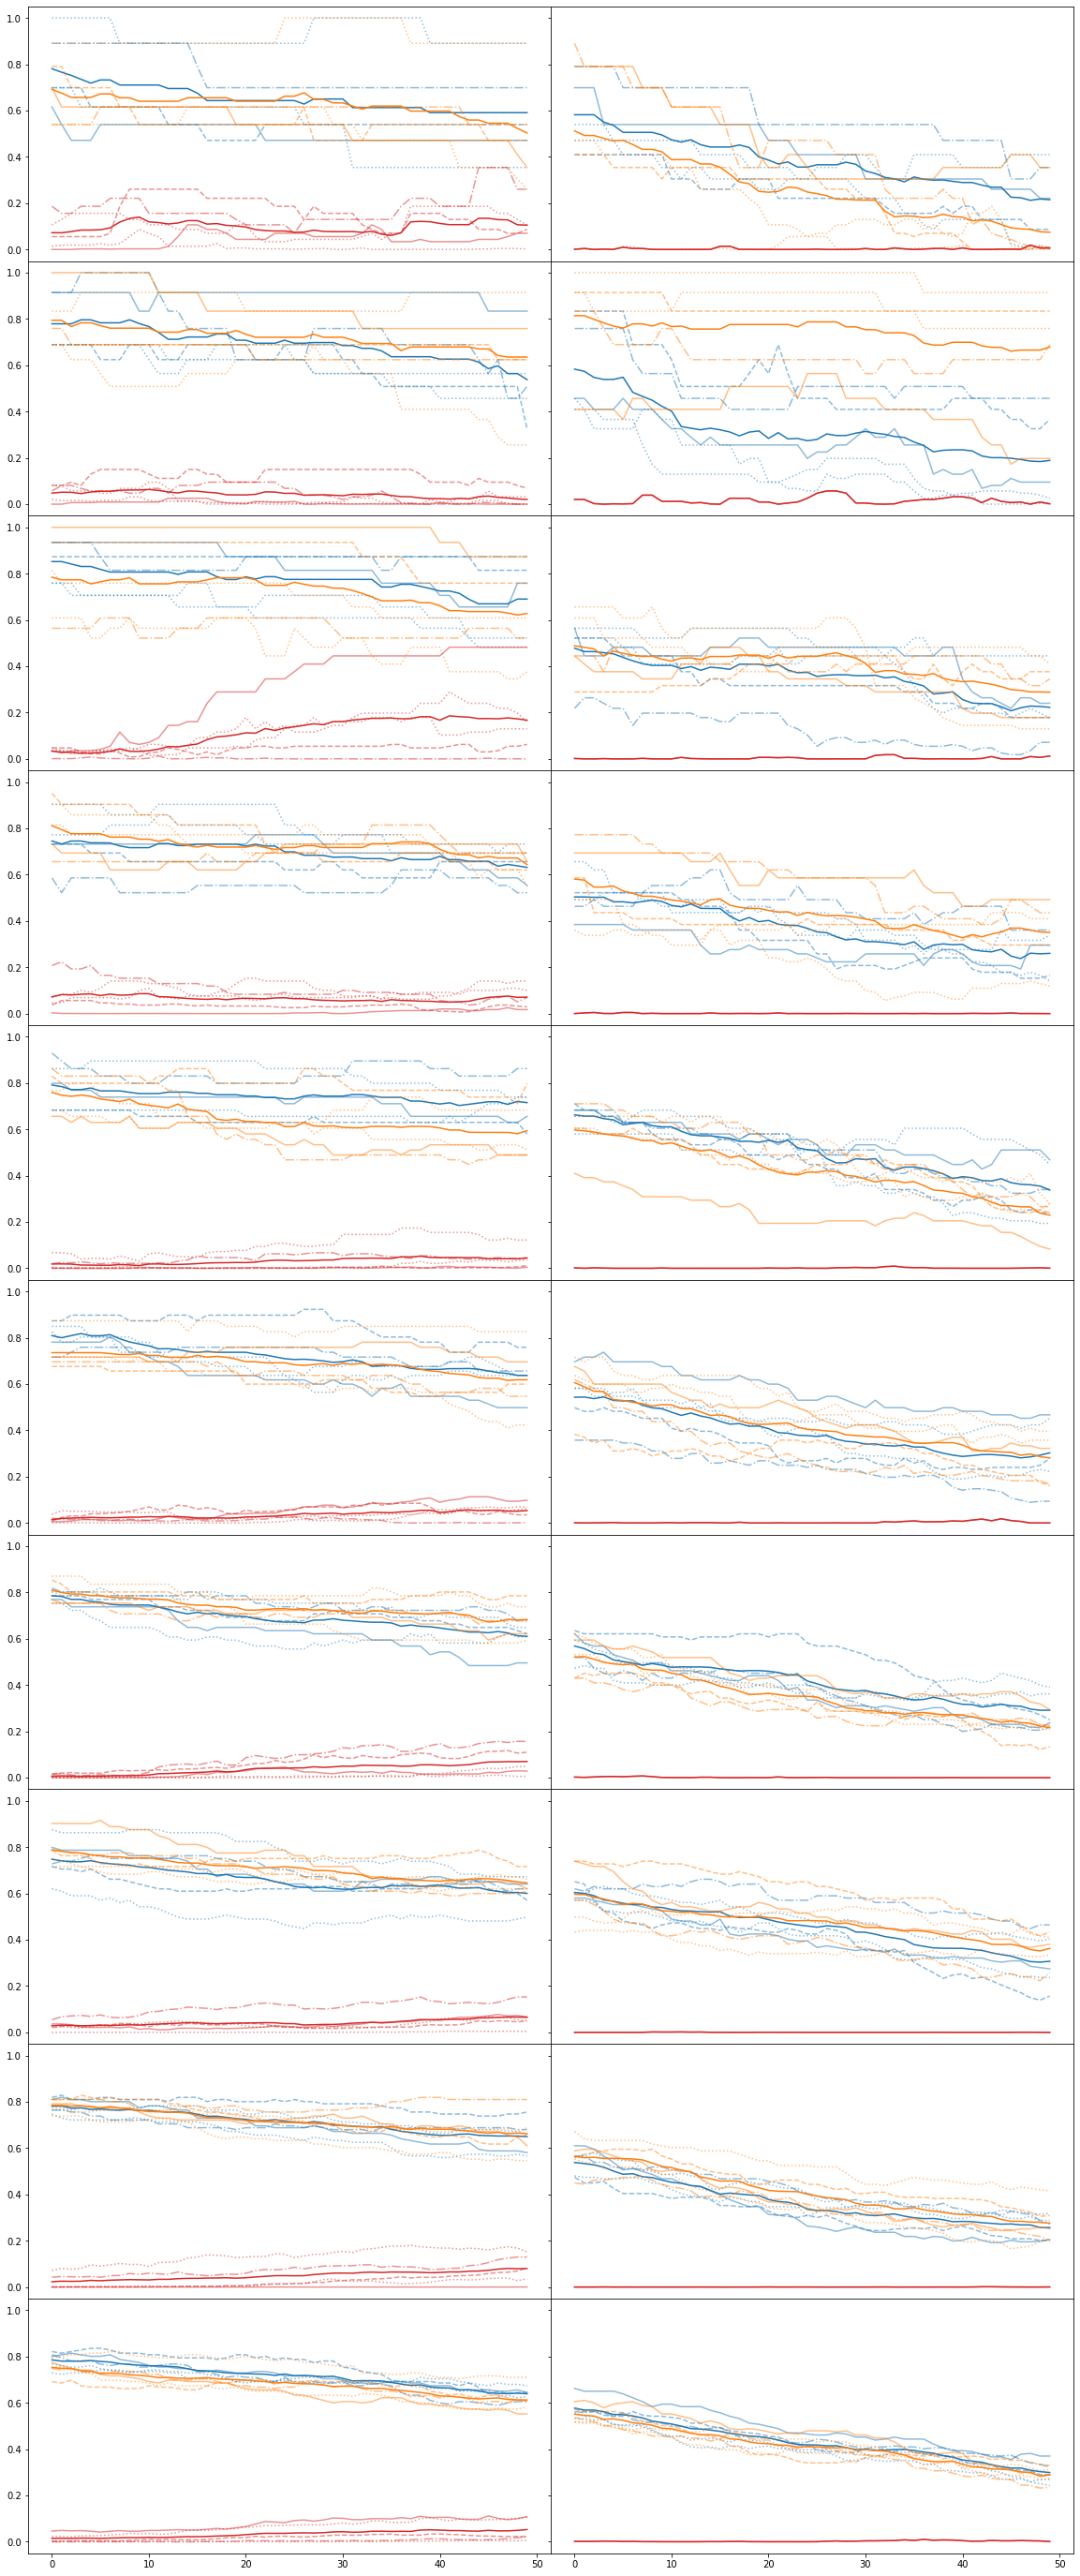

In [10]:
f , axes = plt.subplots(len(o.Ns),2, sharey = 'all', sharex = 'all', figsize = (20,50), gridspec_kw = dict(hspace = 0, wspace = 0))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for N_i, N, row in zip(count(), o.Ns, axes):
    for T_sel, ax in zip([0,1], row):
        for state, color in zip(np.arange(4), colors):
            M2 = np.nanmean(o.Mf_moments[N_i, state, :, T_sel, 4, :], axis = 0)
            ax.plot(np.arange(len(M2)), M2, color = color, linestyle = '-');
            
            for repeat, linestyle in zip(np.arange(5), ['-','--',':','-.',':']):
                M2 = o.Mf_moments[N_i, state, repeat, T_sel, 4, :]
                ax.plot(np.arange(len(M2)), M2, color = color, linestyle = linestyle, alpha = 0.5);

/rds/general/user/tch14/home/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.


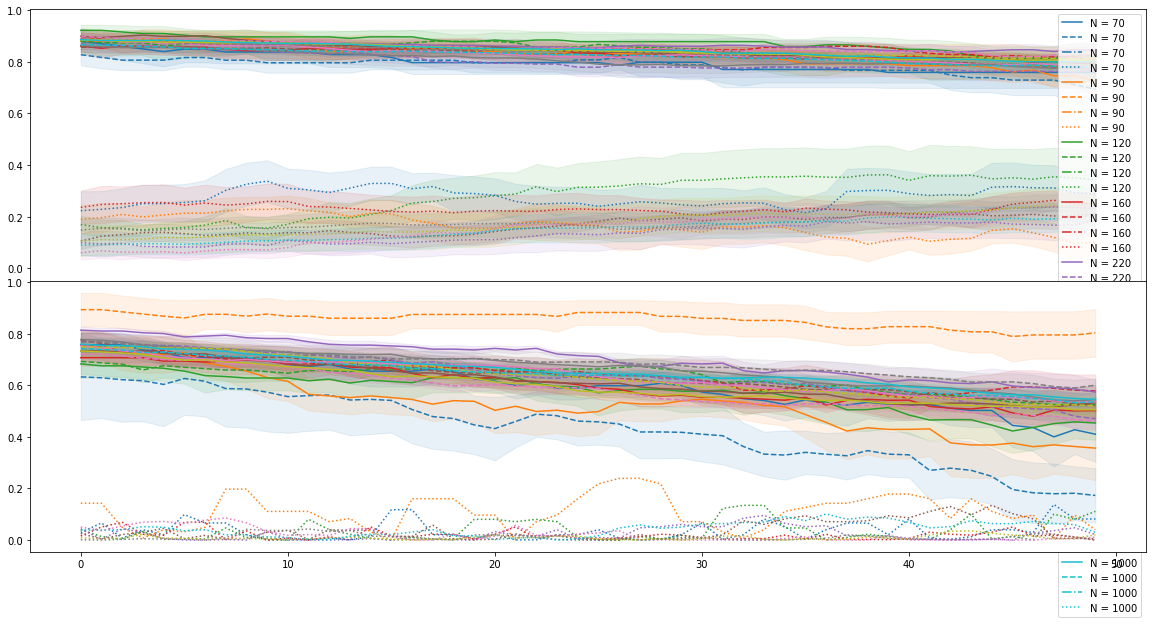

In [7]:
from FKMC.plotting import spread
from scipy.stats import sem

f , axes = plt.subplots(2, sharey = 'all', sharex = 'all', figsize = (20,10), gridspec_kw = dict(hspace = 0, wspace = 0))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for N_i, N, color in zip(count(), o.Ns, colors):
    for T_sel, ax in zip([0,1], axes):
        for state, linestyle in zip(np.arange(4), ['-','--','-.',':']):
            M2 = np.nanmean(o.Mf_moments[N_i, state, :, T_sel, 2, :], axis = 0)
            dM2= sem(o.Mf_moments[N_i, state, :, T_sel, 2, :], axis = 0, nan_policy = 'omit')
            
            ax.plot(np.arange(len(M2)), M2, color = color, linestyle = linestyle, label = f'N = {N}');
            spread(ax, np.arange(len(M2)), M2, dM2, color = color, alpha = 0.1, linestyle = '')
axes[0].legend()

/rds/general/user/tch14/home/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app


[(-0.1, 1.1)]

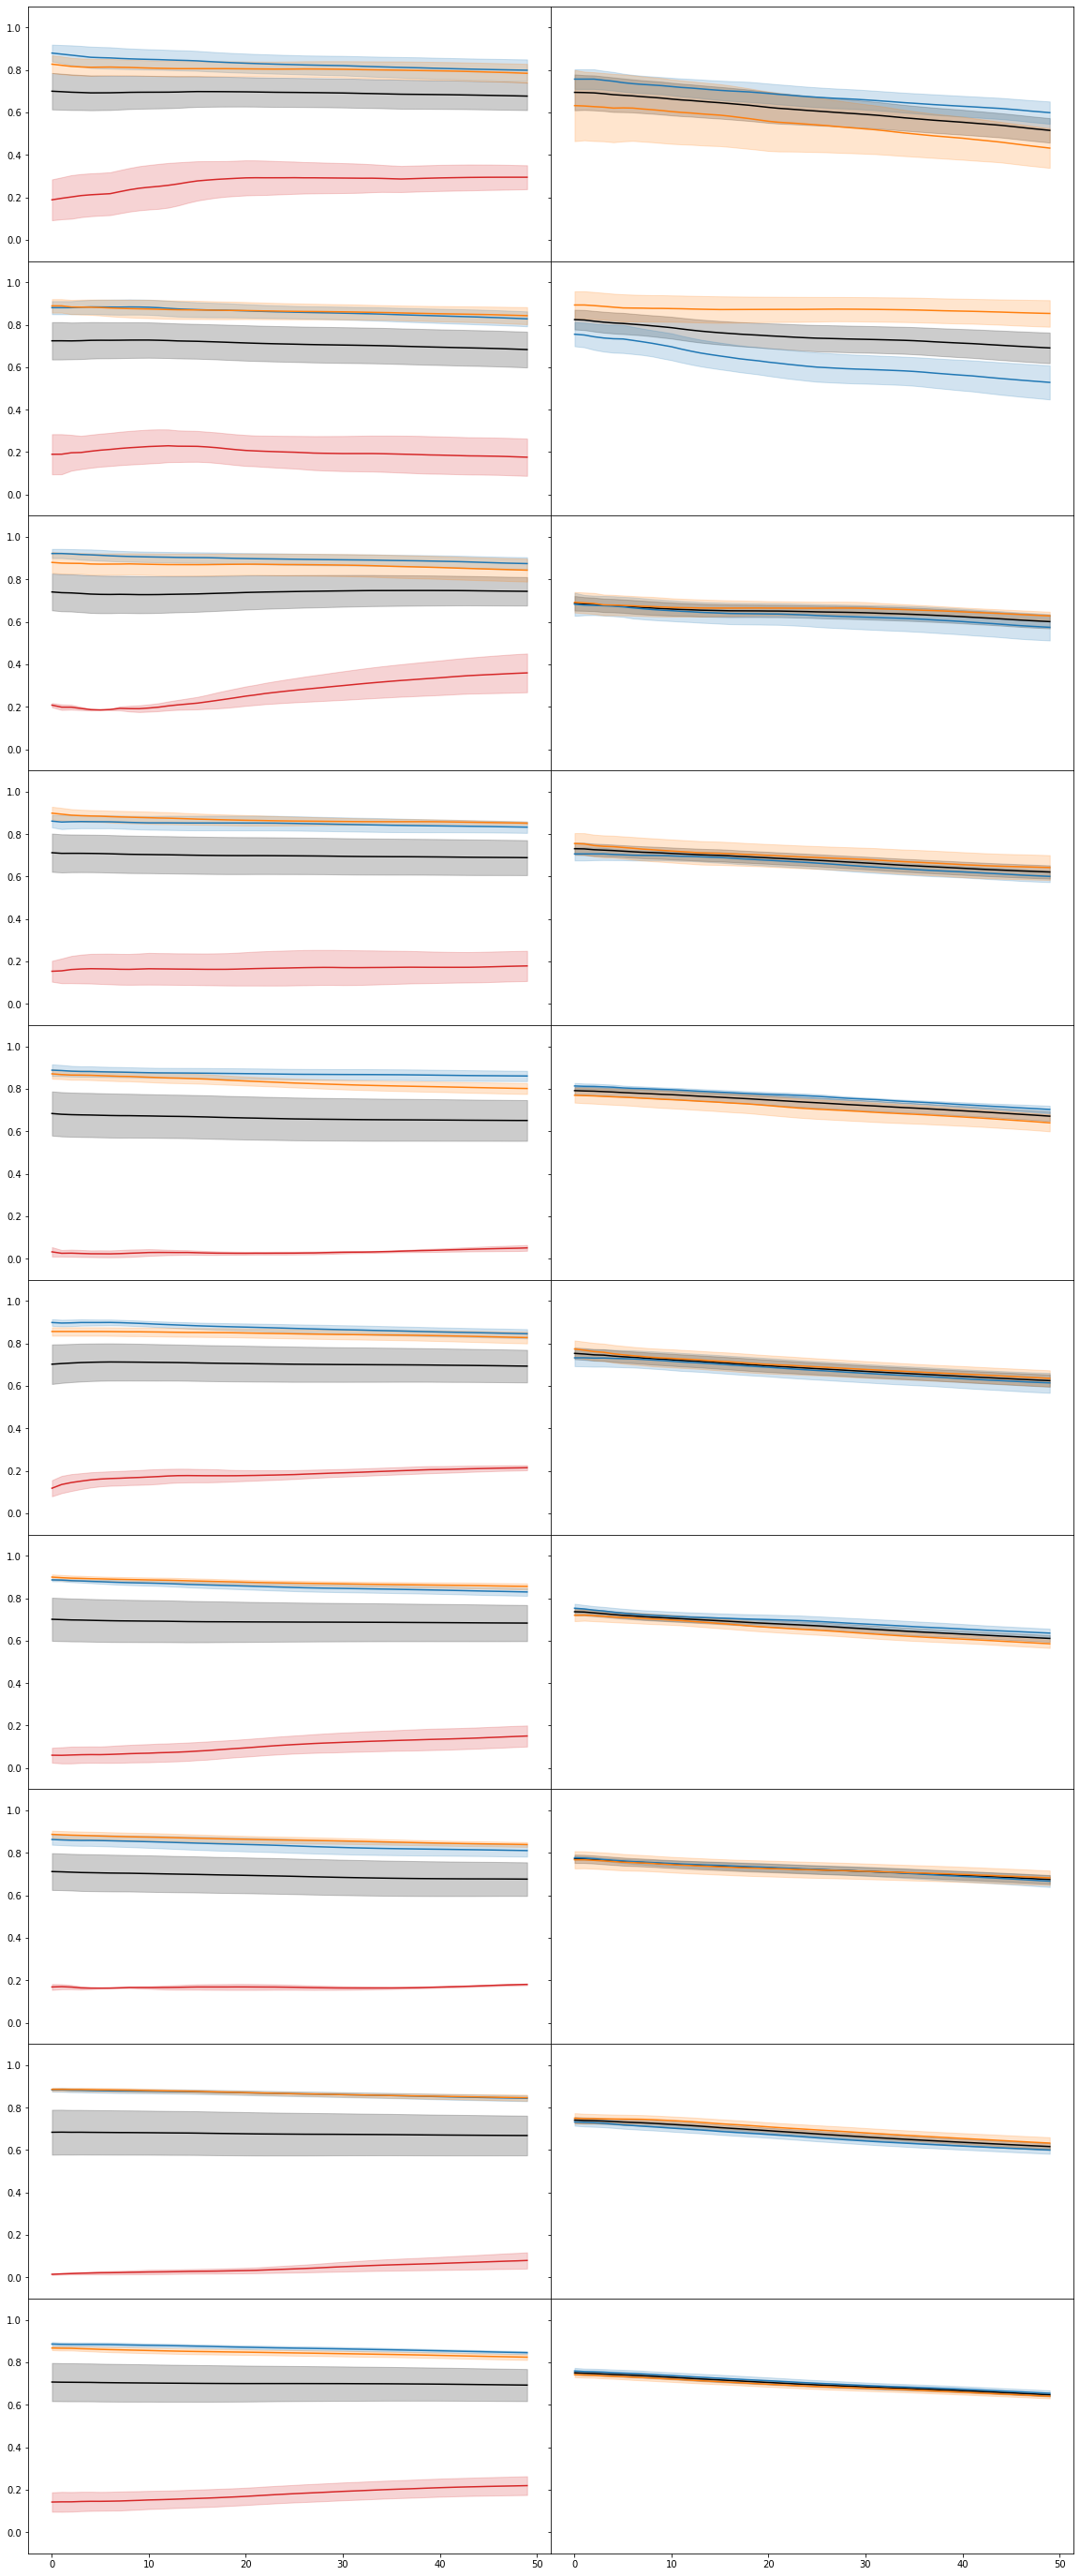

In [218]:
from FKMC.general import running_mean, running_sem

f , axes = plt.subplots(len(o.Ns),2, sharey = 'all', sharex = 'all', figsize = (20,50), gridspec_kw = dict(hspace = 0, wspace = 0))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for N_i, N, row in zip(count(), o.Ns, axes):
    for T_sel, ax in zip([0,1], row):
        M2s = running_mean(o.Mf_moments[N_i, :, :, T_sel, 2, :])
        dM2 = sem(M2s.reshape((-1, M2s.shape[-1])), axis = 0, nan_policy = 'omit')
        M2 = np.nanmean(M2s, axis = (0,1))
        spread(ax, np.arange(len(M2)), M2, dM2, color = 'k', linestyle = '-', alpha = 0.2)
        
        for state, color in zip(np.arange(4), colors):
            dM2 = sem(M2s[state], axis = 0, nan_policy = 'omit')
            M2 = np.nanmean(M2s[state], axis = 0)
            
            spread(ax, np.arange(len(M2)), M2, dM2, color = color, linestyle = '-', alpha = 0.2)
            
            #for repeat, linestyle in zip(np.arange(5), ['-','--',':','-.',':']):
            #    M2 = M2s[repeat]
            #    ax.plot(np.arange(len(M2)), M2, color = color, linestyle = linestyle, alpha = 0.5);

axes[0,0].set(ylim = (-0.1,1.1))

In [194]:
class NamedArray(np.ndarray):

    def __new__(cls, input_array, nape=None):
        # Input array is an already formed ndarray instance
        # We first cast to be our class type
        obj = np.asarray(input_array).view(cls)
        # add the new attribute to the created instance
        obj.nape = np.array(nape or ['?' for _ in np.shape(input_array)])
        # Finally, we must return the newly created object:
        return obj

    def __array_finalize__(self, obj):
        # see InfoArray.__array_finalize__ for comments
        if obj is None: return
        self.nape = getattr(obj, 'nape', None)
        
    def __str__(self):
        s = super().__str__()
        return f'NamedArray({s}, nape = {self.nape})'
    
    def _mean(self, axis, dtype, out, keepdims):
        print('axis = ', axis)
        new_nape = self.nape.delete(axis)
        return NamedArray(super()._mean(self, axis, dtype, out, keepdims), nape = newnape)
    
    def nanmean():
        pass
    
    def sem(self, axis=None, )
        out = scipy.stats.sem(a, axis=0, ddof=1, nan_policy='propagate')
    
a = np.arange(9).reshape((3,3))
a = NamedArray(a, nape = ['x', 'y'])
print(a)
a.mean(axis = 1)

NamedArray([[0 1 2]
 [3 4 5]
 [6 7 8]], nape = ['x' 'y'])


NamedArray([1., 4., 7.])

In [31]:
Dax = Munch(zip(o.hints.DOS, count()))
Dax

Munch({'Ns': 0, 'States': 1, 'Rs': 2, 'Ts': 3, 'energy index': 4})

[2.  2.5]


Text(0.5, 0.98, 'T = 2.5, J = 5, U = 5, M**2 = nan')

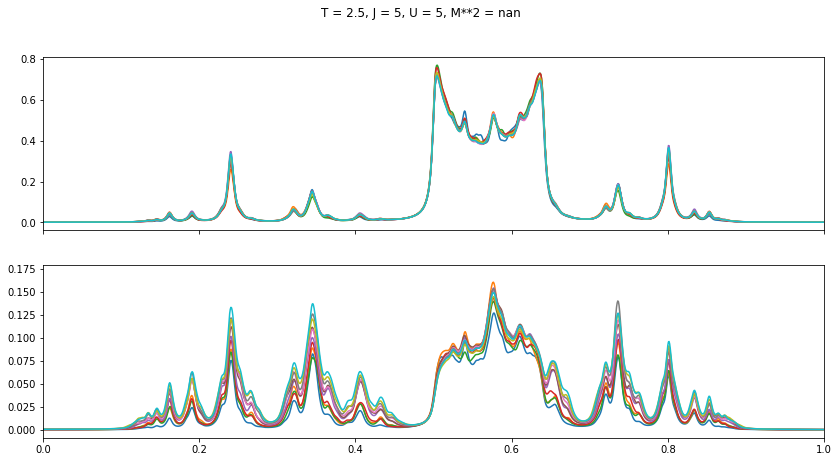

In [38]:
from FKMC.general import smooth
from copy import deepcopy
oS = deepcopy(o)
Dax = Munch(zip(o.hints.DOS, count()))


for i, N in zip(count(), o.Ns):
    scale = 0.1
    for name in ['DOS', 'IPR', 'dDOS', 'dIPR']:
        oS[name][i] = smooth(o[name][i], scale)


f, axes = plt.subplots(2,1, sharex = True, figsize = (14,7))
T_select = 1

DOS = np.nanmean(oS.DOS, axis = (Dax.Rs, Dax.States), keepdims = True) \
            .take([0,], axis = Dax.Ts) \
            .squeeze()
IPR = np.nanmean(oS.IPR, axis = (Dax.Rs, Dax.States), keepdims = True) \
            .take([0,], axis = Dax.Ts) \
            .squeeze()

print(o.Ts)
for i, N in enumerate(o.Ns):
    
    
    axes[0].plot(o.E_bins[1:] / o.parameters.U, DOS[i], label = f'N = {N}')
    axes[1].plot(o.E_bins[1: ] / o.parameters.U, IPR[i])

axes[0].set(xlim = (0, 1))
f.suptitle(f'T = {o.Ts[T_select]}, J = {o.parameters.J}, U = {o.parameters.U}, M**2 = {o.Mf_moments[-1, :, 2].mean():.2f}')

In [11]:
!cat /proc/cpuinfo | grep 'model name' | uniq

model name	: Intel(R) Xeon(R) CPU E5-2620 0 @ 2.00GHz


In [24]:
from scipy.linalg import eigh_tridiagonal
from scipy.linalg.lapack import dstev

def tridiagonal_diagonalisation_benchmark(M = 100, N = 250):
    '''
    diagonalise a system of size 250, 100 times and report how long it took.
    gives 1.6s on cx1
    '''
    t = time()
    states = np.random.choice([0,1], size = [M, N])
    e = -np.ones(N - 1)
    ds = 5*(states - 1/2)
    
    evals = np.zeros(shape = [M,N])
    evecs = np.zeros(shape = [M,N,N])
    
    for i in range(M):
        #evals[i], evecs[i] = eigh_tridiagonal(d = ds[i], e = e, lapack_driver = 'stev')
        evals[i], evecs[i], info =  dstev(d = ds[i], e = e, compute_v = True)
        
    return time() - t

tridiagonal_diagonalisation_benchmark(M = 1, N = 4000)

20.358768939971924